In [1]:
##
import numpy as np
import pandas as pd

import gc
import os
from matplotlib import pyplot as plt
import rasterio
import geopandas as gpd
from rasterio.plot import show, show_hist
import rasterio
import rasterio.mask as Mask
import rasterio.features
import rasterio.warp
from rasterio.plot import show_hist
import fiona
import os
import glob
import shapely
from shapely.geometry import LineString, Polygon, Polygon, Point, MultiPoint, MultiPolygon
from functools import partial
import pyproj
import shapely
from shapely.ops import transform
from tqdm import tqdm_notebook, tqdm
## help with figure rotation
from scipy import ndimage, misc
from shapely.geometry import Point
import geopandas as gpd
import cv2   # usse to resize images so that every image would have the same size!!!! 
## GDAL_DATA environment problem
os.environ['GDAL_DATA'] = '/opt/anaconda3/pkgs/libgdal-2.3.3-h0950a36_0/share/gdal'
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, cohen_kappa_score, roc_auc_score, accuracy_score


In [12]:
def concat_bands(name='L1C_T53HPA_A004418_20180110T005319', 
                 BASE = '/Volumes/My Passport for Mac/sentinel_2_53HPA/',
                 #OUT='/Volumes/My Passport for Mac/'
                 ):
    '''Resize all bands to (5490, 5490), resolution at 20meter/pixel'''

    b01 = rasterio.open(BASE+name+'_b01.tif').read(1)
    b01 = np.expand_dims(cv2.resize(b01, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b09 = rasterio.open(BASE+name+'_b09.tif').read(1)
    b09 = np.expand_dims(cv2.resize(b09, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b10 = rasterio.open(BASE+name+'_b10.tif').read(1)
    b10 = np.expand_dims(cv2.resize(b10, (5490,5490)), axis=2)[3000:4000,2200:3200,:]

    b02 = rasterio.open(BASE+name+'_b02.tif').read(1)
    b02 = np.expand_dims(cv2.resize(b02, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b03 = rasterio.open(BASE+name+'_b03.tif').read(1)
    b03 = np.expand_dims(cv2.resize(b03, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b04 = rasterio.open(BASE+name+'_b04.tif').read(1)
    b04 = np.expand_dims(cv2.resize(b04, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b08 = rasterio.open(BASE+name+'_b08.tif').read(1)
    b08 = np.expand_dims(cv2.resize(b08, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    tci = rasterio.open(BASE+name+'_tci.tif').read(1)
    tci = np.expand_dims(cv2.resize(tci, (5490,5490)), axis=2)[3000:4000,2200:3200,:]

    b05 = np.expand_dims(rasterio.open(BASE+name+'_b05.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b06 = np.expand_dims(rasterio.open(BASE+name+'_b06.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b07 = np.expand_dims(rasterio.open(BASE+name+'_b07.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b8A = np.expand_dims(rasterio.open(BASE+name+'_b8A.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b11 = np.expand_dims(rasterio.open(BASE+name+'_b11.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b12 = np.expand_dims(rasterio.open(BASE+name+'_b12.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    
    concat = np.concatenate([b01,b02,b03,b04,b05,b06,b07,b08,b09,b10,b11,b12,b8A,tci],axis=-1)
    concat = np.expand_dims(concat, 0)
    return concat

def expand_nbr(name='L1C_T53HPA_A004418_20180110T005319', 
                 BASE = '/Volumes/My Passport for Mac/sentinel_2_53HPA/',
                 #OUT='/Volumes/My Passport for Mac/'
                 A=200
                 ):
    
    ## add 200 paddings outwards!
    smooth=1e-5
    b08 = rasterio.open(BASE+name+'_b08.tif').read(1)
    b08 = np.expand_dims(cv2.resize(b08, (5490,5490)), axis=2)[3000-A:4000+A,2200-A:3200+A,:]
    b12 = np.expand_dims(rasterio.open(BASE+name+'_b12.tif').read(1), axis=2)[3000-A:4000+A,2200-A:3200+A,:]
    nbr = (b08-b12+smooth)/(b08+b12+smooth)
    nbr = np.expand_dims(nbr, 0)
    return nbr


bigquery_res = pd.read_csv('/Volumes/My Passport for Mac/sentinel_2_53HPA/bigquery_results_s.csv', index_col=0)
bigquery_res['sensing_time'] = pd.to_datetime(bigquery_res['sensing_time'])
bigquery_res = bigquery_res[bigquery_res['cloud_cover']<75]
bigquery_res = bigquery_res.reset_index(drop=True)


In [151]:
bigquery_res['granule_id'].values.tolist()

['L1C_T53HPA_A004418_20180110T005319',
 'L1C_T53HPA_A013398_20180115T005320',
 'L1C_T53HPA_A004847_20180209T004659',
 'L1C_T53HPA_A013827_20180214T004702',
 'L1C_T53HPA_A004990_20180219T005320',
 'L1C_T53HPA_A005133_20180301T004657',
 'L1C_T53HPA_A014113_20180306T004702',
 'L1C_T53HPA_A005276_20180311T004657',
 'L1C_T53HPA_A005562_20180331T004702',
 'L1C_T53HPA_A014542_20180405T004706',
 'L1C_T53HPA_A014685_20180415T004707',
 'L1C_T53HPA_A005848_20180420T004704',
 'L1C_T53HPA_A014828_20180425T005334',
 'L1C_T53HPA_A014971_20180505T004708',
 'L1C_T53HPA_A006134_20180510T004704',
 'L1C_T53HPA_A015114_20180515T004708',
 'L1C_T53HPA_A015257_20180525T004708',
 'L1C_T53HPA_A006420_20180530T005610',
 'L1C_T53HPA_A006563_20180609T005611',
 'L1C_T53HPA_A015543_20180614T004705',
 'L1C_T53HPA_A015686_20180624T004706',
 'L1C_T53HPA_A006992_20180709T005232',
 'L1C_T53HPA_A015972_20180714T004707',
 'L1C_T53HPA_A007135_20180719T005247',
 'L1C_T53HPA_A016115_20180724T004707',
 'L1C_T53HPA_A007278_2018

In [41]:
id_names = bigquery_res['granule_id'].values.tolist()
id_names.extend(['L1C_T53HPA_A015000_20200120T005618','L1C_T53HPA_A023980_20200125T004659', 'L1C_T53HPA_A015143_20200130T005534'])
id_names = id_names[-7:]


In [42]:
for i in tqdm_notebook(range(len(id_names))):
    if i == 0:
        imgs = concat_bands(id_names[i])
        exp_nbr = expand_nbr(name=id_names[i])
    else:
        imgs = np.concatenate([imgs, concat_bands(id_names[i])])
        exp_nbr = np.concatenate([exp_nbr, expand_nbr(name=id_names[i])],0)


In [43]:
adjacency = np.zeros((len(exp_nbr)-1,1400,1400,1))
for i in range(len(exp_nbr)-1):
    adjacency[i,:] = exp_nbr[i,:] - exp_nbr[i+1,:]

dnbr = adjacency[:,200:1200,200:1200,:]
water_mask = np.load('../../water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)

labs = (dnbr>0.66).astype(int)
for i in range(len(labs)):
    labs[i,:][water_mask==1] = 0

    

In [35]:
class Data(object):
    def __init__(self, imgs, labs, zone_idx=np.arange(25)):
        self.imgs = imgs
        self.labs = labs
        self.size = len(labs)
        self.zone_idx = zone_idx

    def extract_single_zone(self, imgs, labs, idx=0):
        """extract a single zone based on the index"""
        assert idx >= 0 and idx <= 24
        try:
            assert len(imgs) == self.size
        except Exception:
            imgs = imgs[:self.size,:]     ## if there are more images than labels, cut the images to approporiate size!
        try:
            assert len(labs) == self.size
        except Exception:
            labs = labs[:self.size,:]     

        row_idx = idx//5
        col_idx = idx%5
        return imgs[:, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :], labs[:, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :]
   
    def burn_ratio(self, labs):
        """calculate the burn ratio in an area"""
        ratio = np.zeros((labs.shape[0],))
        for i in range(len(labs)):
            ratio[i] = labs[i,:,:,:].mean()
        return ratio

    def binarize_risk(self, labs, thres=0.05):
        #ratio = labs.sum(axis=-1).sum(axis=-1).sum(axis=-1)/(200*200)
        ratio = self.burn_ratio(labs)
        return (ratio>thres).astype(int)

    def compile_zones(self):
        """concatenate all sector images based on selected index"""
        """Zone 0,0,0,0,0,0,0,0,0 .... Zone 1,1,1,1...."""
        """Normalize to (0, 1) !!!"""
        imgs, labs = self.extract_single_zone(self.imgs, self.labs, idx=self.zone_idx[0])
        for i in range(1, len(self.zone_idx)):
            I, L = self.extract_single_zone(self.imgs, self.labs, idx=self.zone_idx[i])
            imgs = np.concatenate([imgs, I], 0)
            labs = np.concatenate([labs, L], 0)
        imgs = imgs/imgs.max()
        imgs = imgs.astype('float32')
        return imgs, labs
        
    def prepare_step_data(self):
        zoned_imgs, zoned_labs = self.compile_zones()
        idx = np.array([i for i in range(len(zoned_imgs)) if i % self.size not in [self.size-2, self.size-1, self.size]])
        imgs_0 = zoned_imgs[idx, :,:,:]
        imgs_1 = zoned_imgs[idx+1, :,:,:]
        imgs_2, labs = zoned_imgs[idx+2, :,:,:], self.binarize_risk(zoned_labs[idx+2])
        return imgs_0, imgs_1, imgs_2, labs
    

In [44]:
test_data = Data(imgs[1:], labs[1:])
test_imgs_0, test_imgs_1, test_imgs_2, test_labs = test_data.prepare_step_data()


In [45]:
test_labs.shape

(75,)

In [50]:
class Adjacency(object):
    """Only to extract burn ratio from label, no images, no binarized labels, burn ratio is the feature to extract"""
    def __init__(self, labs, zone_idx=np.arange(25)):
        self.labs = labs
        self.size = len(labs)
        self.zone_idx = zone_idx
    
    def extract_single_zone(self, labs, idx=0):
        """extract a single zone based on the index"""
        assert idx >= 0 and idx <= 24
        try:
            assert len(labs) == self.size
        except Exception:
            labs = labs[:self.size,:]     
        row_idx = idx//5
        col_idx = idx%5
        return labs[:, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :]

    def burn_ratio(self,labs):
        """calculate the burn ratio in an area"""
        ratio = np.zeros((labs.shape[0],))
        for i in range(len(labs)):
            ratio[i] = labs[i,:,:,:].mean()
        return ratio
    
    def binarize_risk(self,labs, thres=0.05):
        ratio = labs.sum(axis=-1).sum(axis=-1).sum(axis=-1)/(200*200)
        return (ratio>thres).astype(int)

    def compile_zones(self):
        """concatenate all sector images based on selected index"""
        """Zone 0,0,0,0,0,0,0,0,0 .... Zone 1,1,1,1...."""
        """Normalize to (0, 1) !!!"""
        labs = self.extract_single_zone(self.labs, idx=self.zone_idx[0])
        for i in range(1, len(self.zone_idx)):
            L = self.extract_single_zone(self.labs, idx=self.zone_idx[i])
            labs = np.concatenate([labs, L], 0)
        return labs

    def prepare_step_data(self):
        zoned_labs = self.compile_zones()
        idx = np.array([i for i in range(len(zoned_labs)) if i % self.size not in [self.size-2, self.size-1, self.size]])
        adj_0 = self.burn_ratio(zoned_labs[idx])
        adj_1 = self.burn_ratio(zoned_labs[idx+1])
        adj_2 = self.burn_ratio(zoned_labs[idx+2])
        return adj_0, adj_1, adj_2
    
def extract_adjacency_feature(adjacency, indices=[np.arange(25)]):
    """
    Function to extract adjacency features
    indices must be in list format,
    mode can be either trn_val or test
    """
    names = ['south','southwest','west','northwest','north','northeast','east','southeast']
    
    def subset_adjacency(adjacency, which=0):
        """Extract adjacency feature based on 1 direction"""
        name = names[which]
        row = 200
        col = 200
        if 'south' in name:
            row = 400
        elif 'north' in name:
            row = 0
        if 'west' in name:
            col = 0
        elif 'east' in name:
            col = 400
        return adjacency[:,row:row+1000,col:col+1000,:]
    
    test_adj_0_list = []
    test_adj_1_list = []
    test_adj_2_list = []

    test_idx = indices[0]
    for i in tqdm_notebook(range(8)):
        #adjacency_full = np.load('/content/gdrive/My Drive/adjacency.npz')['dnbr']
        adj_s = subset_adjacency(adjacency, which=i)
        adj_s = (adj_s>0.66).astype(int)
        #adjacency = np.concatenate([np.zeros((1,1000,1000,1), dtype='int'), adjacency[:-1]],0)
        
        test_data = Adjacency(adj_s, zone_idx=test_idx)
        del adj_s
        gc.collect()
        test_adj_0, test_adj_1, test_adj_2 = test_data.prepare_step_data()
        del test_data
        gc.collect()
        test_adj_0_list.append(test_adj_0)
        test_adj_1_list.append(test_adj_1)
        test_adj_2_list.append(test_adj_2)

    test_adj_0_list = np.column_stack(test_adj_0_list)
    test_adj_1_list = np.column_stack(test_adj_1_list)
    test_adj_2_list = np.column_stack(test_adj_2_list)

    return test_adj_0_list, test_adj_1_list, test_adj_2_list
    

In [62]:
test_adj_0, test_adj_1, test_adj_2 = extract_adjacency_feature(adjacency[:-1])


In [75]:
gsod = pd.read_csv('/Users/jincui/Downloads/fc_gsod_2019_2020.csv')[['year','mo','da','temp','dewp','slp','visib','wdsp','mxpsd','max','min','prcp','rain_drizzle']]
gsod['date'] = gsod['year'].map(str) + '-' + gsod['mo'].map(str) + '-' + gsod['da'].map(str) 
gsod = gsod.drop(['year','mo','da'],1)
gsod.head()

,temp,dewp,slp,visib,wdsp,mxpsd,max,min,prcp,rain_drizzle,date
0,48.6,42.2,1027.6,999.9,8.0,8.9,58.8,43.0,0.00,0,2019-10-9
1,50.2,46.3,1013.7,8.7,8.0,15.9,60.6,47.7,0.47,1,2019-9-20
2,55.5,44.9,1024.2,999.9,10.7,15.9,64.2,48.0,0.00,0,2019-4-17
3,56.3,53.0,1028.9,999.9,8.4,13.0,64.0,50.2,0.00,0,2019-5-15
4,55.9,42.9,1018.7,999.9,16.6,18.1,58.1,40.1,0.00,0,2019-8-30


In [79]:
rqd_dates = ['2019-12-31','2020-1-1','2020-1-2','2020-1-3','2020-1-4',
             '2020-1-5', '2020-1-6', '2020-1-7', '2020-1-8', '2020-1-9',
             '2020-1-15','2020-1-16','2020-1-17','2020-1-18','2020-1-19',
             '2020-1-20','2020-1-21','2020-1-22','2020-1-23','2020-1-24',             
             '2020-1-25'
            ]

In [87]:
gsod_s = gsod[gsod['date'].isin(rqd_dates)].sort_values(by='date')
gsod_s['dewp'][gsod_s['dewp']>9999] = 47.9
gsod_s['visib'][gsod_s['visib']>999] = 11.5

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [104]:
### have to manually sort them
#gsod_s.to_csv('test_set_gsod.csv')

In [108]:
gsod_s = pd.read_csv('test_set_gsod.csv')
gsod_s.head()

,temp,dewp,slp,visib,wdsp,mxpsd,max,min,prcp,rain_drizzle,date
0,61.2,49.7,1016.6,11.5,8.2,12.0,68.7,55.8,0.0,0,12/31/19
1,62.2,52.6,1018.8,11.5,9.1,11.1,71.4,52.7,0.0,0,1/1/20
2,70.0,50.2,1012.4,11.5,11.9,18.1,77.4,52.5,0.0,0,1/2/20
3,70.4,52.9,1008.3,11.5,14.6,21.0,89.4,57.9,0.0,0,1/3/20
4,57.7,50.0,1019.5,11.5,10.8,13.0,62.8,52.7,0.0,0,1/4/20


In [136]:
day_0 = gsod_s[gsod_s['date'].isin(['12/31/19', '1/5/20', '1/15/20', '1/20/20','1/25/20'])]
day_1 = gsod_s[gsod_s['date'].isin(['1/1/20', '1/6/20', '1/16/20', '1/21/20'])]
day_2 = gsod_s[gsod_s['date'].isin(['1/2/20', '1/7/20', '1/17/20', '1/22/20'])]
day_3 = gsod_s[gsod_s['date'].isin(['1/3/20', '1/8/20', '1/18/20', '1/23/20'])]
day_4 = gsod_s[gsod_s['date'].isin(['1/4/20', '1/9/20', '1/19/20', '1/24/20'])]

day_0.columns = [*map(lambda t:t+'_0' if t!='date' else t, day_0.columns)]
day_1.columns = [*map(lambda t:t+'_1' if t!='date' else t, day_1.columns)]
day_2.columns = [*map(lambda t:t+'_2' if t!='date' else t, day_2.columns)]
day_3.columns = [*map(lambda t:t+'_3' if t!='date' else t, day_3.columns)]
day_4.columns = [*map(lambda t:t+'_4' if t!='date' else t, day_4.columns)]


day_0 = day_0.reset_index(drop=True)
day_1 = day_1.reset_index(drop=True)
day_2 = day_2.reset_index(drop=True)
day_3 = day_3.reset_index(drop=True)
day_4 = day_4.reset_index(drop=True)

day_0 = day_0.drop(['date'],1)
day_1 = day_1.drop(['date'],1)
day_2 = day_2.drop(['date'],1)
day_3 = day_3.drop(['date'],1)
day_4 = day_4.drop(['date'],1)


In [139]:
x = pd.read_csv('flinders_chase_clean_5day.csv')
x.max()

temp_0              84.90
dewp_0              58.00
slp_0             1035.30
visib_0             20.20
wdsp_0              22.60
mxpsd_0             28.00
max_0               96.60
min_0               72.50
prcp_0               0.83
rain_drizzle_0       1.00
temp_1              87.80
dewp_1              60.20
slp_1             1036.90
visib_1             21.70
wdsp_1              23.90
mxpsd_1             35.90
max_1               96.30
min_1               68.40
prcp_1               1.02
rain_drizzle_1       1.00
temp_2              83.10
dewp_2              65.10
slp_2             1035.20
visib_2             20.20
wdsp_2              23.90
mxpsd_2             29.90
max_2              102.90
min_2               67.30
prcp_2               0.79
rain_drizzle_2       1.00
temp_3              91.40
dewp_3              63.40
slp_3             1036.00
visib_3             18.60
wdsp_3              22.20
mxpsd_3             28.00
max_3              102.40
min_3               84.00
prcp_3      

In [142]:
test_gsod_final = pd.concat([day_0,day_1,day_2,day_3,day_4],1)
test_gsod_final = test_gsod_final/x.max()

test_gsod_final.to_csv('test_gsod_final.csv',index=False)

In [66]:
np.savez_compressed('/Users/jincui/Downloads/test_data', 
                    test_imgs_0=test_imgs_0, test_imgs_1=test_imgs_1, test_imgs_2=test_imgs_2,
                    test_adj_0=test_adj_0, test_adj_1=test_adj_1, test_adj_2=test_adj_2,
                    test_lab=test_labs
                   )

In [143]:
test_preds_0 = np.load('/Users/jincui/Downloads/test_preds_0.npy')
test_preds_1 = np.load('/Users/jincui/Downloads/test_preds_1.npy')
test_preds_2 = np.load('/Users/jincui/Downloads/test_preds_2.npy')
test_preds_3 = np.load('/Users/jincui/Downloads/test_preds_3.npy')
test_preds_4 = np.load('/Users/jincui/Downloads/test_preds_4.npy')


In [147]:
test_preds_mean = 0.2*(test_preds_0+test_preds_1+test_preds_2+test_preds_3+test_preds_4)
test_preds_mean

array([0.840253  , 0.9302212 , 0.01128374, 0.8851005 , 0.965022  ,
       0.00595178, 0.8598493 , 0.43754473, 0.01117484, 0.5447962 ,
       0.14422469, 0.00254124, 0.9303482 , 0.4908762 , 0.01920432,
       0.8296928 , 0.6796395 , 0.54820204, 0.8528177 , 0.67073864,
       0.20249338, 0.75870913, 0.3873553 , 0.00918862, 0.67475396,
       0.20742245, 0.01386807, 0.7860603 , 0.27197298, 0.19932497,
       0.88314736, 0.12063827, 0.20329659, 0.8695542 , 0.20982201,
       0.34265053, 0.8486245 , 0.28928065, 0.18203793, 0.8554104 ,
       0.2620772 , 0.09301674, 0.8721229 , 0.27399397, 0.20236953,
       0.8960096 , 0.03314256, 0.20321147, 0.8842315 , 0.03665832,
       0.20319319, 0.86486286, 0.31197396, 0.20229542, 0.8951492 ,
       0.2997783 , 0.20265113, 0.94117016, 0.25459442, 0.20293887,
       0.97304153, 0.22141123, 0.9617333 , 0.9007109 , 0.9686697 ,
       0.757399  , 0.9316972 , 0.6137701 , 0.78414226, 0.89369076,
       0.09957247, 0.5431736 , 0.91514677, 0.15515755, 0.69162

In [149]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, cohen_kappa_score

print(accuracy_score(test_labs, test_preds_mean.round().flatten()))
print(f1_score(test_labs, test_preds_mean.round().flatten()))
print(fbeta_score(test_labs, test_preds_mean.round().flatten(),2))
print(fbeta_score(test_labs, test_preds_mean.round().flatten(),3))
print(fbeta_score(test_labs, test_preds_mean.round().flatten(),4))
print(cohen_kappa_score(test_labs, test_preds_mean.round().flatten()))
print(recall_score(test_labs, test_preds_mean.round().flatten()))
print(precision_score(test_labs, test_preds_mean.round().flatten()))


0.9333333333333333
0.9295774647887325
0.953757225433526
0.9620991253644315
0.9655765920826161
0.866500533997864
0.9705882352941176
0.8918918918918919


In [34]:
smooth = 1e-5
b08 = imgs[:,:,:,7:8] 
b12 = imgs[:,:,:,11:12]
nbr = (b08-b12+smooth)/(b08+b12+smooth)

dnbr = np.zeros((5,1000,1000,1))
for i in range(5):
    dnbr[i,:] = nbr[i+1,:] - nbr[i,:]

In [35]:
dnbr.shape

(5, 1000, 1000, 1)

In [37]:
#np.savez_compressed('test_data', exp_dnbr=exp_dnbr, imgs=imgs, dnbr=dnbr)


In [ ]:
### Generate test set gsod features
local_records_day_0 = pd.read_csv('/Users/jincui/Downloads/landsat_analysis/fc_day_0.csv').drop(['date'],1)
local_records_day_1 = pd.read_csv('/Users/jincui/Downloads/landsat_analysis/fc_day_1.csv').drop(['date'],1)
local_records_day_2 = pd.read_csv('/Users/jincui/Downloads/landsat_analysis/fc_day_2.csv').drop(['date'],1)
local_records_day_3 = pd.read_csv('/Users/jincui/Downloads/landsat_analysis/fc_day_3.csv').drop(['date'],1)
local_records_day_4 = pd.read_csv('/Users/jincui/Downloads/landsat_analysis/fc_day_4.csv').drop(['date'],1)

local_records_day_0.columns = [*map(lambda t: t+'_0', local_records_day_0.columns)]
local_records_day_1.columns = [*map(lambda t: t+'_1', local_records_day_1.columns)]
local_records_day_2.columns = [*map(lambda t: t+'_2', local_records_day_2.columns)]
local_records_day_3.columns = [*map(lambda t: t+'_3', local_records_day_3.columns)]
local_records_day_4.columns = [*map(lambda t: t+'_4', local_records_day_4.columns)]
gsod_5day = pd.concat([local_records_day_0.iloc[-2:,:],
           local_records_day_1.iloc[-2:,:], 
           local_records_day_2.iloc[-2:,:], 
           local_records_day_3.iloc[-2:,:], 
           local_records_day_4.iloc[-2:,:]
          ],1)

# Had to manuall fill in some weather data from https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/2020/
##gsod_5day.to_csv('test_gsod_features.csv', index=False)

In [83]:
labs = (dnbr[3:,:,:,:]>0.66).astype(int)
labs.shape

(2, 1000, 1000, 1)

In [84]:
zones_labs = []
for i in range(25):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    zones_labs.append(labs[:,row_idx:row_idx+200,col_idx:col_idx+200,0])
zones_risk = np.array([*map(lambda t:(t.sum(axis=-1).sum(axis=-1) >= (0.05*200*200)).astype(int), zones_labs)])
zones_risk = np.swapaxes(zones_risk,0,1)

risks = np.zeros(labs.shape)
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(25)):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    for j in range(len(labs)):
        if labs[j,row_idx:row_idx+200,col_idx:col_idx+200,0].sum() >= 0.05*200*200:
            risks[j,row_idx:row_idx+200,col_idx:col_idx+200,0] = 1

Text(0.5, 1.0, 'Predicted labels\n F2 score: 0.278')

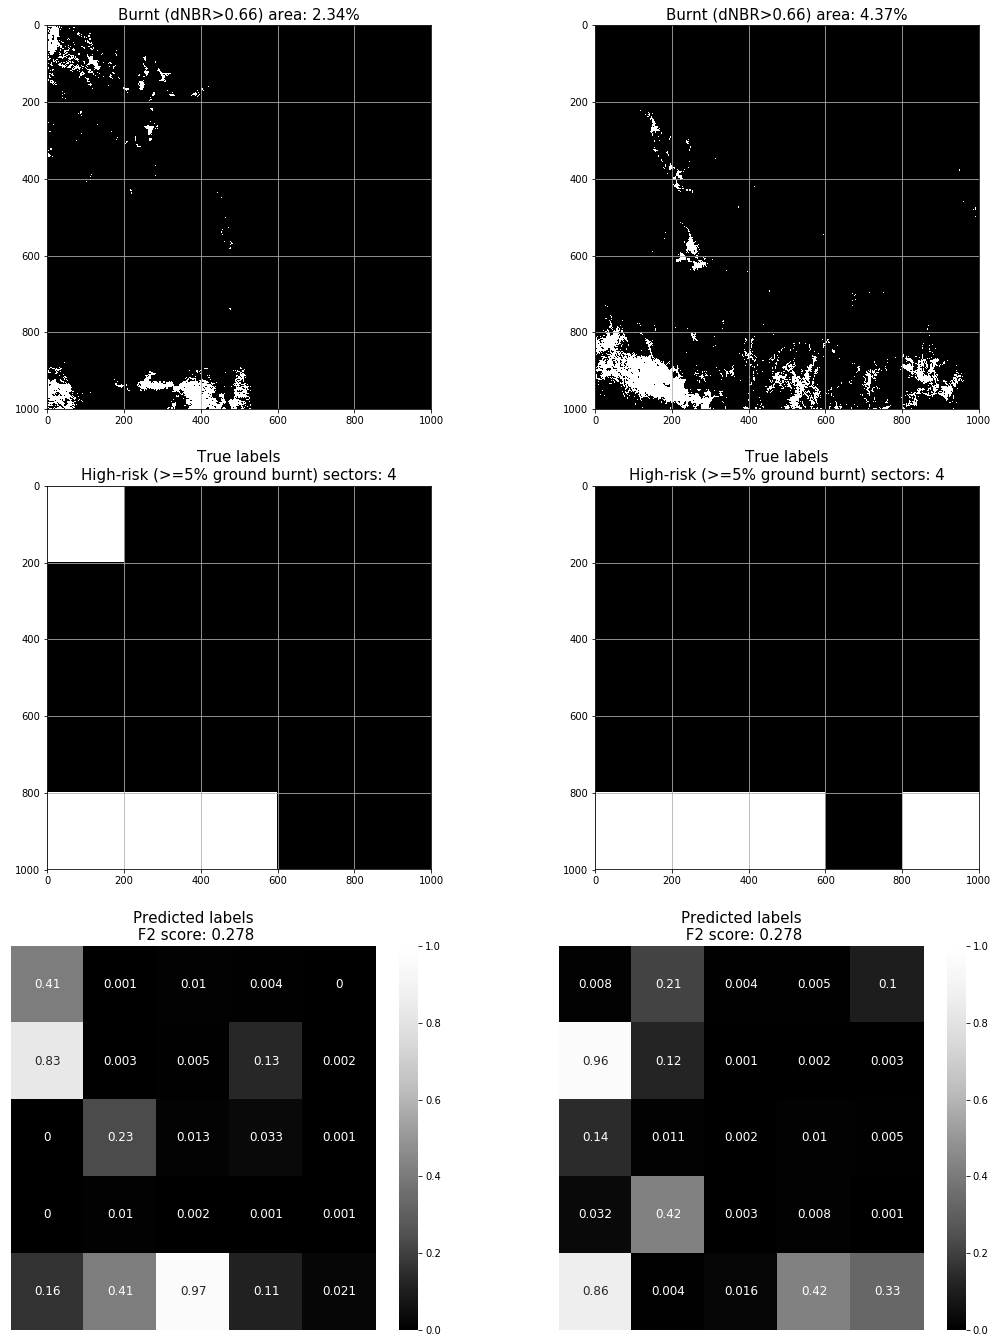

In [99]:
title_fontsize = 15
plt.figure(figsize=(18,24))

plt.subplot(3,2,1)
plt.grid()
plt.imshow(labs[0,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
plt.title(f"Burnt (dNBR>0.66) area: {(100*(labs[0,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)
plt.subplot(3,2,2)
plt.grid()
plt.imshow(labs[1,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
plt.title(f"Burnt (dNBR>0.66) area: {(100*(labs[1,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)


plt.subplot(3,2,3)
plt.grid()
plt.imshow(risks[0,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
plt.title(f"True labels\nHigh-risk (>=5% ground burnt) sectors: {zones_risk[0].sum()}", fontsize=title_fontsize)
plt.subplot(3,2,4)
plt.grid()
plt.imshow(risks[1,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
plt.title(f"True labels\nHigh-risk (>=5% ground burnt) sectors: {zones_risk[1].sum()}", fontsize=title_fontsize)


plt.subplot(3,2,5)
cm = preds[0,:]
annot = preds[0,:].round(3)
sns.heatmap(cm, annot=annot, annot_kws={"size": 12}, cmap="Greys_r", cbar=True, vmin=0, vmax=1,
            yticklabels=False, xticklabels=False)
plt.title(f"Predicted labels\n F2 score: {fbeta_score(zones_risk[0,:], (preds[0,:]>0.5).flatten().astype(int), 2).round(3)}", fontsize=title_fontsize)

plt.subplot(3,2,6)
cm = preds[1,:]
annot = preds[1,:].round(3)
sns.heatmap(cm, annot=annot, annot_kws={"size": 12}, cmap="Greys_r", cbar=True, vmin=0, vmax=1,
            yticklabels=False, xticklabels=False)
plt.title(f"Predicted labels\n F2 score: {fbeta_score(zones_risk[1,:], (preds[1,:]>0.5).flatten().astype(int), 2).round(3)}", fontsize=title_fontsize)


In [107]:
l = ['2018-02','2018-03']

In [109]:
sorted(l, reverse=True)

['2018-03', '2018-02']

In [114]:
#!cd /Volumes/My\ Passport\ for\ Mac/sentinel_2_53HPA/ && gsutil cp -r gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE .


Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/DATASTRIP/DS_SGS__20200130T020548_S20200130T005534/MTD_DS.xml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/DATASTRIP/DS_SGS__20200130T020548_S20200130T005534/QI_DATA/FORMAT_CORRECTNESS.xml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/DATASTRIP/DS_SGS__20200130T020548_S20200130T005534/QI_DATA/GENERAL_QUALITY.xml...
\ [3 files][  5.8 MiB/  5.8 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T0

Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_DETFOO_B02.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_DETFOO_B03.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_DETFOO_B04.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_DETFOO_B05.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_DETFOO_B06.gml...
Copying gs://gcp-public-data-sentin

Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_TECQUA_B06.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_TECQUA_B07.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_TECQUA_B08.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_TECQUA_B09.gml...
Copying gs://gcp-public-data-sentinel-2/tiles/53/H/PA/S2B_MSIL1C_20200130T004659_N0208_R102_T53HPA_20200130T020548.SAFE/GRANULE/L1C_T53HPA_A015143_20200130T005534/QI_DATA/MSK_TECQUA_B10.gml...
Copying gs://gcp-public-data-sentin

In [106]:
np.save('test_preds.npy', preds)

In [105]:
preds = np.array([0.4132, 0.001,0.01, 0.004, 0.0004,
                  0.832, 0.003, 0.005, 0.132, 0.0021,
                  0.0004, 0.231, 0.013, 0.033, 0.001,
                  0.0001, 0.01, 0.002, 0.001, 0.001,
                  0.163, 0.412, 0.966, 0.112, 0.021,
                  
                  0.008, 0.209, 0.004, 0.005, 0.101,
                  0.961, 0.122, 0.001, 0.002, 0.003,
                  0.142, 0.011, 0.002, 0.01, 0.005,
                  0.032, 0.422, 0.003, 0.008, 0.001,
                  0.862, 0.004, 0.016, 0.424,0.332                  
                 ]).reshape((2,5,5))
